# NLP From Scratch: Translation with a Sequence to Sequence Network and Attention

In this project we will be teaching a neural network to translate from German to English.


This is made possible by the simple but powerful idea of the [sequence
to sequence network](https://arxiv.org/abs/1409.3215), in which two
recurrent neural networks work together to transform one sequence to
another. An encoder network condenses an input sequence into a vector,
and a decoder network unfolds that vector into a new sequence.


To improve upon this model we'll use an [attention
mechanism](https://arxiv.org/abs/1409.0473), which lets the decoder
learn to focus over a specific range of the input sequence.

## Dependencies

In [1]:
# using Python 3.9
%pip install pandas torch matplotlib numpy ipython


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\feror\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [91]:
from __future__ import unicode_literals, print_function, division
import os
from io import open
import unicodedata
import string
import re
import random
import time
import math
import pandas as pd

from IPython.display import Image
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Loading & preprocessing training data

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation. We then implement a parsing funciton that reads a csv file from the specified path, normalizes every sentence in the dataset using the normalize function, and returns a list of (german_sentence, english_sentence) pairs. If the parameter reverse is True, the order of languages in the tuple are reversed resulting in reverse translation.



In [92]:
# https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


def parse_data(path, reverse=False):

  pairs = pd.read_csv(path)
  pairs['GER'] = pairs['GER'].apply(normalize_string)
  pairs['ENG'] = pairs['ENG'].apply(normalize_string)

  if reverse:
    pairs = pairs[['ENG', 'GER']]

  return pairs

Since there are a *lot* of example sentences and we want to train
something quickly, we'll trim the data set to only relatively short and
simple sentences and we will avoid explicit questions. Hence we will set a maximum sentence length of 10 words (that includes punctuation) and remove questions.



In [93]:
MAX_WORDS = 10

interrogative_words = ( "what", "why", "how", "which", "where", "when" , "who", "whose",
                        "was", "warum", "wie", "welche", "wo", "wann", "wer", "wieso")

"""
TODO: Task 1 (10 pt)

Implement the filter_pairs function so that it takes in a pd.DataFrame of language pairs and outputs another dataframe where following pairs are removed:

- those where one of both exceeds the maximal sentence length (MAX_WORDS)
- those where the pair contains any of the words defined in interrogative_words or a question mark.

Note: your method should NOT employ any explicit iteration (i.e. for loops).

"""
def filter_pairs(pairs, drop_words=interrogative_words, max_words=MAX_WORDS):
    # Split sentences into words and count them
    count_words = lambda sentence: len(sentence.split())
    pairs['GER_len'] = pairs['GER'].apply(count_words)
    pairs['ENG_len'] = pairs['ENG'].apply(count_words)

    # Filter out sentences longer than max_words
    pairs = pairs[(pairs['GER_len'] <= max_words) & (pairs['ENG_len'] <= max_words)]

    # Check for the presence of interrogative words or question marks
    interrogative_pattern = '|'.join(drop_words) + r'|\?'
    pairs = pairs[~(pairs['GER'].str.contains(interrogative_pattern) | pairs['ENG'].str.contains(interrogative_pattern))]

    # Drop the temporary length columns
    pairs.drop(['GER_len', 'ENG_len'], axis=1, inplace=True)

    return pairs

Each word in a language will be represented as a one-hot
vector, or giant vector of zeros except for a single one (at the index
of the word). Compared to the dozens of characters that might exist in a
language, there are many many more words, so the encoding vector is much
larger. We will however cheat a bit and trim the data to only use a few
thousand words per language.

We'll need a unique index per word to use as the inputs and targets of
the networks later. To keep track of all this we will use a helper class
called ``Language`` which has word → index (``word2index``) and index → word
(``index2word``) dictionaries, as well as a count of each word
``word2count`` which will be used to replace rare words later.




In [94]:
SOS_token = 0
EOS_token = 1

"""
TODO: Task 2 (10 pt)

Implement the function remove_rare_words, that removes words whose frequency is below
min_freq and makes sure that the size of the vocabulary is below max_vocab_size
by iteratively removing least frequent words. 

The function should also update the indices in the dictionary, so that no index 
is left unused (i.e. all values from 0 to n_words are indices) and all variables are up-to-date. 

You might want to define a helper method remove_word to break down the task.

"""


class Language:
    def __init__(self):
        self.word2index = {} # maps word to integer index
        self.word2count = {} # maps word to its frequency
        self.index2word = {0: "SOS", 1: "EOS"} # maps index to a word
        self.n_words = 2  # Count SOS and EOS

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    def remove_word(self, word):
        """ Remove a word from the language dictionaries. """
        if word in self.word2index:
            del self.word2count[word]
            index = self.word2index[word]
            del self.word2index[word]
            del self.index2word[index]

    def remove_rare_words(self, min_freq, max_vocab_size):
        # Remove words below the frequency threshold
        for word in list(self.word2count):
            if self.word2count[word] < min_freq:
                self.remove_word(word)

        # If vocabulary size is still too large, remove least frequent words
        while len(self.word2index) > max_vocab_size:
            least_freq_word = min(self.word2count, key=self.word2count.get)
            self.remove_word(least_freq_word)

        # Update the indices to make them continuous
        self.word2index = {word: idx for idx, (word, _) in enumerate(self.word2count.items())}
        self.index2word = {idx: word for word, idx in self.word2index.items()}
        self.n_words = len(self.word2index) + 2  # including SOS and EOS

    def trim(self, max_vocab_size):
        # Ensure max_vocab_size accounts for SOS and EOS tokens
        max_vocab_size -= 2  # Adjust for SOS and EOS

        # Sort words by frequency
        all_words = sorted(self.word2count.items(), key=lambda x: x[1], reverse=True)

        # Keep only the top `max_vocab_size` words
        trimmed_words = all_words[:max_vocab_size]

        # Reinitialize dictionaries
        self.word2index = {"SOS": 0, "EOS": 1}
        self.word2count = {"SOS": 0, "EOS": 0}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

        for word, count in trimmed_words:
            self.add_word(word)
        
    
           



The full process for preparing the data is:

-  Read text file and split into lines, split lines into pairs
-  Normalize text, filter by length and content
-  Make word lists from sentences in pairs




In [95]:
def prepare_data(pairs, reverse=False):

    print(f"Read {len(pairs)} sentence pairs")
    pairs = filter_pairs(pairs)
    print(f"Filtered {len(pairs)} sentence pairs")
    pairs = pairs.to_numpy()

    input_lang = Language()
    output_lang = Language()

    for pair in pairs:
        input_lang.add_sentence(pair[0])
        output_lang.add_sentence(pair[1])

    print(f"Input language: {input_lang.n_words} words")
    print(f"Output language: {output_lang.n_words} words")
    return input_lang, output_lang, pairs



In [96]:
path = os.path.join(os.getcwd(), "data", "translations.csv")
pairs = parse_data(path)
input_lang, output_lang, pairs = prepare_data(pairs, reverse=True)
### SHOW NOTEBOOK OUTPUT ###

Read 255817 sentence pairs
Filtered 131442 sentence pairs
Input language: 12521 words
Output language: 24253 words


## Encoder-decoders

A Recurrent Neural Network, or RNN, is a network that operates on a
sequence and uses its own output as input for subsequent steps.

A [Sequence to Sequence network](https://arxiv.org/abs/1409.3215)_, or
seq2seq network, or [Encoder Decoder
network](https://arxiv.org/pdf/1406.1078v3.pdf)_, is a model
consisting of two RNNs called the encoder and decoder. The encoder reads
an input sequence and outputs a single vector, and the decoder reads
that vector to produce an output sequence.

Unlike sequence prediction with a single RNN, where every input
corresponds to an output, the seq2seq model frees us from sequence
length and order, which makes it ideal for translation between two
languages, because there usally is not a 1:1 mapping between words.


### The Encoder

The encoder of a seq2seq network is a RNN that outputs some value for
every word from the input sentence. For every input word the encoder
outputs a vector and a hidden state, and uses the hidden state for the
next input word.

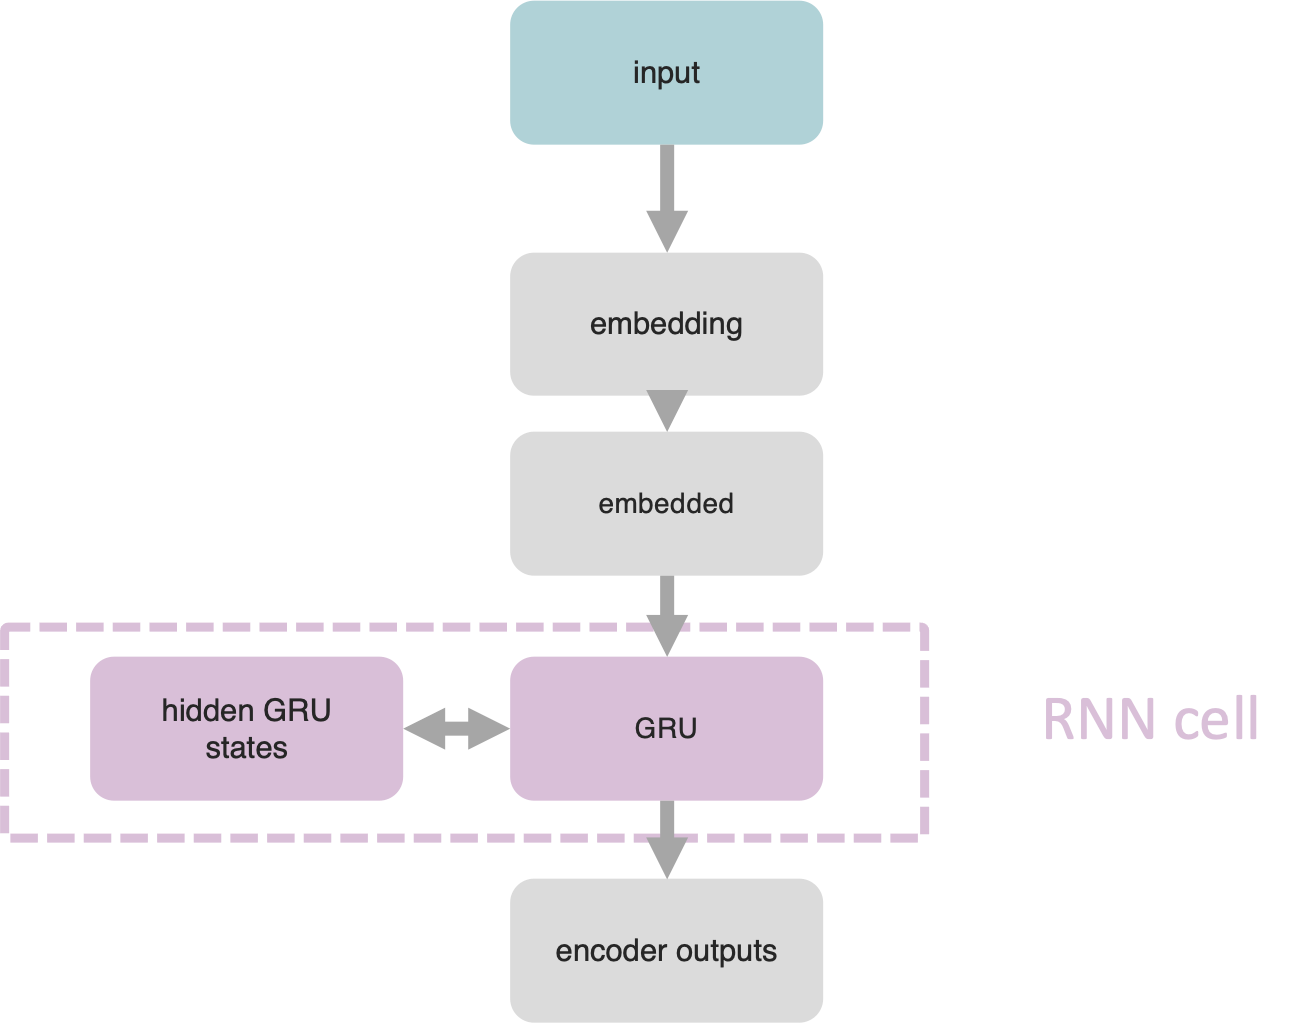

In [71]:
Image(filename="img/encoder.png", height=400)

In [97]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, rnn_type='GRU', batch_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.rnn_type = rnn_type

        self.embedding = nn.Embedding(input_size, hidden_size) #produces a list of vect
        self.rnn = getattr(nn, rnn_type)(self.hidden_size, self.hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1) # translates input (series of indices for the respective words) into their vector representation
        output, hidden = self.rnn(embedded, hidden)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_size, device=device)

Although all encoders must have certain distinctive features to be called as such, as for example the ability to process sequences of different length returning fixed-length hidden states, it is not required for them to have a recurrent structure. In fact, most state-of-the art NLP models use transformer layers, combining attention layers with feed-forward network for a higher parallelizability. Because transformer layers process information in parallel, they have no inherent mechanisms that makes them aware of the position of the word in the sentence and need to engineer a feature that encodes that information.

In [98]:
"""
TODO: Task 3 (10 pt)

Implement a positional encoding module for an alternative encoder using transformers.
The positional encoder should create a vector of size max_length containing the
discrete values of a function f(x) applied on the even features of the input
and g(x) applied on the odd features of the input.
f(x) should be defaulted to sine, g(x) to cosine.
Their value should be scaled by div_term.

Briefly describe (3-4 sentences):

- why sinusoidal are used by default
- how div_term impacts the encoding
- which characteristics would make a function a suitable
  alternative to sinusoidals.

Note: you are not expected to train the TransformerEncoder (this will most likely
not work due to incompatibility with the train method). Simply show you can initialize
the encoder and pass a tensor through it.

"""
class PositionalEncoding(nn.Module):
    def __init__(self, hidden_size, max_length, even_fc=torch.sin, odd_fc=torch.cos):
        super().__init__()
        # Compute the positional encodings once in log space
        pe = torch.zeros(max_length, hidden_size)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, hidden_size, 2).float() * -(math.log(10000.0) / hidden_size))
        pe[:, 0::2] = even_fc(position * div_term)
        pe[:, 1::2] = odd_fc(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return x
    
class TransformerEncoder(nn.Module):

    def __init__(self, input_size, hidden_size, max_length=MAX_WORDS, batch_size=1):

        super().__init__()
        self.hidden_size = hidden_size
        self.batch_size = batch_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.positional_encoding = PositionalEncoding(hidden_size, max_length)
        self.transformer_layers = nn.TransformerEncoderLayer(hidden_size, nhead=4)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_layers, num_layers=6)
        self.fc = nn.Linear(hidden_size, hidden_size)

    def forward(self, input, positional_encoding=False):
    
        
        embedded = self.embedding(input) # translates input (series of indices for the respective words) into their vector representation
        
        # If true, applies positional encoding
        if positional_encoding:
            embedded = self.positional_encoding(embedded).view(1, 1, -1)

        # Transformer encoder layers
        transformer_output = self.transformer_encoder(embedded)

        # Fully connected layer
        output = self.fc(transformer_output)

        return output

#### Answer:
- Sinusoidal functions (sine for even indices, cosine for odd indices) are used because they provide a smooth and continuous way to encode position information. These functions allow the model to easily learn to attend by relative positions since for any fixed offset k, sin(pos+k) and cos(pos+k) can be linearly represented through a combination of sin(pos) and cos(pos). This property helps the model to generalize to sequence lengths unseen during training.
- The div_term is a scaling factor that decreases the amplitude of the sinusoidal wave as the dimension increases. This is important because it allows the model to distinguish between lower and higher dimensions in the positional encoding.
- Suitable alternatives to sinusoidal functions should ideally have properties that allow the model to deduce relative positions (like the linear representability of sinusoids). They should be continuous and smoothly varying to help the model learn and generalize across different positions. Also, these functions should ideally vary across different dimensions to provide a unique encoding for each position in the sequence.

In [99]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

attn_encoder = TransformerEncoder(input_lang.n_words, 256)
input = tensorFromSentence(input_lang, pairs[0][0])
attn_encoder(input)
### SHOW NOTEBOOK OUTPUT ###

tensor([[[ 1.4082e-01, -5.1464e-01,  2.2455e-01, -1.2776e-01,  1.9368e-01,
          -4.8330e-01,  6.3358e-02,  2.9163e-01, -5.1780e-01,  5.4082e-01,
           1.8633e-01,  8.5424e-01,  2.8592e-01, -6.7502e-01,  8.5238e-01,
          -1.5201e-01,  1.1045e+00,  1.0164e+00,  6.0656e-01,  5.9507e-01,
          -7.9032e-01,  5.0676e-02, -1.7161e-01,  4.8588e-01,  9.1924e-01,
          -4.3132e-01, -5.1360e-02,  6.0097e-01, -1.2716e-01,  6.5076e-01,
          -1.0868e+00,  1.5286e-01, -4.0024e-01, -4.7907e-01,  3.1153e-01,
           2.0256e-01, -1.8698e-01, -2.1765e-01, -5.5380e-01,  1.2381e+00,
          -9.7507e-01,  3.3456e-01,  8.9808e-02, -5.4739e-01, -1.9915e+00,
          -4.4963e-01,  3.3624e-01, -1.3274e+00,  6.3277e-02, -2.7816e-01,
           9.6950e-01,  1.9273e+00,  7.2166e-01, -2.6460e-01,  2.5215e-01,
          -1.8208e-01, -6.3749e-01, -6.9269e-01, -7.7319e-01,  4.4056e-01,
           5.5747e-01,  1.1899e+00, -6.0265e-01, -6.5661e-01,  8.6995e-01,
           4.1694e-01,  3

### The Decoder

The decoder is another RNN that takes the encoder output vector(s) and
outputs a sequence of words to create the translation.




#### Attention Decoder


Attention allows the decoder network to "focus" on a different part of the encoder's outputs for every step of the decoder's own outputs.
For this, we determine a set of attention weights which capture which part of the sentence is most important for the translation.
The attention weights will be multiplied by the encoder output vectors to create a weighted combination.
The result should contain information about that specific part of the input sequence, and thus help the decoder choose the right output words.

Specifically, this is done as follows:
1. Attention weights are calculated with a feed-forward layer (`self.attn`) using the concatenated decoder's input and hidden state as inputs and appying a softmax to it.
   * Because there are sentences of all sizes in the training data, to actually create and train this layer we have to choose a maximum sentence length (input length, for encoder outputs) that it can apply to. Sentences of the maximum length will use all the attention weights, while shorter sentences will only use the first few.
1. The attention weights will be multiplied by the encoder output vectors to create a weighted combination (using `torch.bmm()`).
1. The encoder outputs weighted by the attention weights are concatenated (use `torch.cat`) with the decoder's embeddings and fed into another feed-forward layer (`self.attn_combine`).
1. ReLu is applied on the output of the attention module.



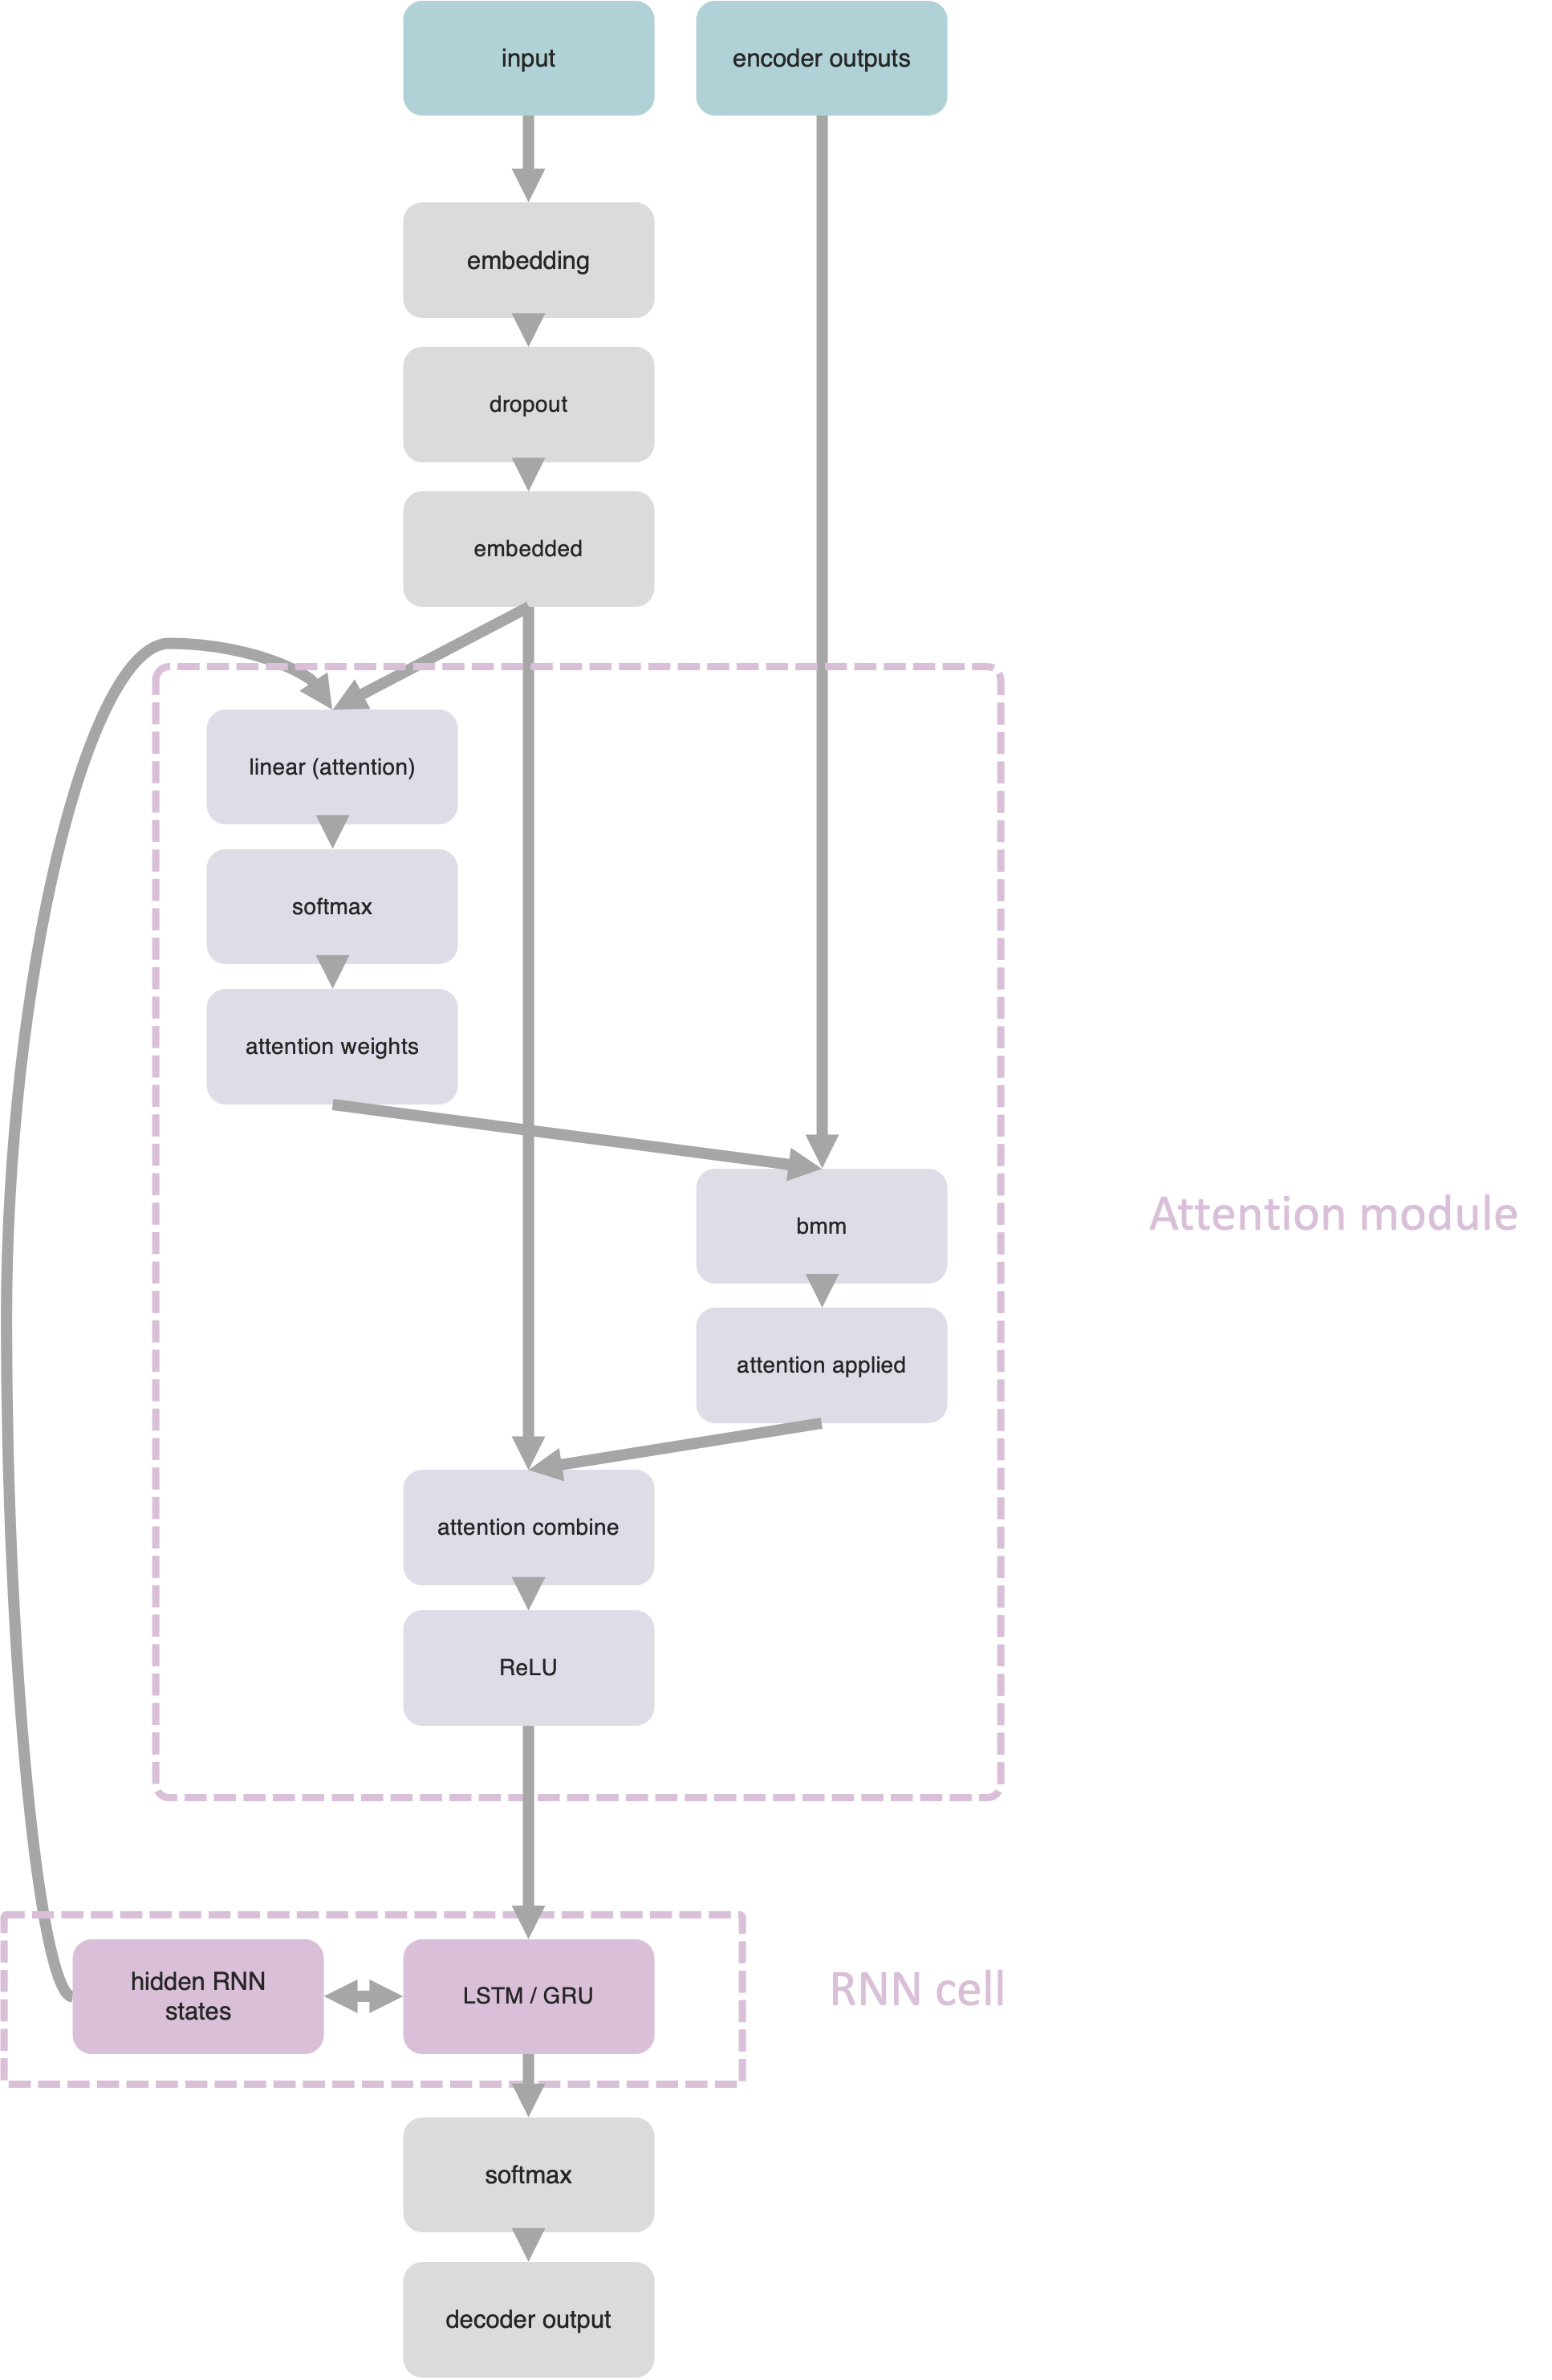

In [112]:
Image(filename="img/decoder.png", height=900)

In [100]:
"""
TODO: Task 4 (10 pt)
Implement the attention layer as described above and depicted in the figure.

Show the train progress (3-5 min) when using the decoder with attention on the translation task (see "Pre-trained GRU seq2seq model" section below).

"""
class Attention(nn.Module):
    def __init__(self, hidden_size, max_length):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        # Define layers for the attention mechanism
        self.attn = nn.Linear(self.hidden_size * 2, max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)

    def forward(self, embedded, hidden, encoder_outputs):
        # Concatenate embedded input word and hidden state
        attn_input = torch.cat((embedded[0], hidden[0]), 1)
        
        # Calculate attention weights
        attn_weights = F.softmax(self.attn(attn_input), dim=1)

        # Apply attention weights to encoder outputs
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        # Combine attention applied outputs with embedded input word
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        # Apply activation function
        output = F.relu(output)

        return output


In [101]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, rnn_type='GRU', rnn_n_layers=1, batch_size=1, max_length=MAX_WORDS+1):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.rnn_type = rnn_type
        self.rnn_n_layers = rnn_n_layers
        self.batch_size = batch_size

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.attention = Attention(self.hidden_size, self.max_length)
        self.rnn = getattr(nn, self.rnn_type)(self.hidden_size, self.hidden_size, self.rnn_n_layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        c0 = self.init_hidden()
        # h0 = self.init_hidden() # reuse hidden state of LSTM/GRU cell or reinitialize?

        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        if self.rnn_type == 'LSTM':
            attn_hidden = hidden[0] # only hidden, not cell state
        else:
            attn_hidden = hidden # GRU has no cell state

        output = self.attention(embedded, attn_hidden, encoder_outputs)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output[0])
        output = F.log_softmax(output, dim=1)

        return output, hidden

    def init_hidden(self):
        weights = torch.zeros(self.rnn_n_layers, self.batch_size, self.hidden_size, device=device)
        return (weights, weights) if self.rnn_type == 'LSTM' else weights


# Training

### Preparing Training Data

To train, for each pair we will need an input tensor (indexes of the
words in the input sentence) and target tensor (indexes of the words in
the target sentence). While creating these vectors we will append the
EOS token to both sequences.




In [102]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

### Training the Model

To train we run the input sentence through the encoder, and keep track
of every output and the latest hidden state. Then the decoder is given
the `<SOS>` token as its first input, and the last hidden state of the
encoder as its first hidden state.

"Teacher forcing" is the concept of using the real target outputs as
each next input, instead of using the decoder's guess as the next input.
Using teacher forcing causes it to converge faster but [when the trained
network is exploited, it may exhibit
instability](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.378.4095&rep=rep1&type=pdf).

You can observe outputs of teacher-forced networks that read with
coherent grammar but wander far from the correct translation -
intuitively it has learned to represent the output grammar and can "pick
up" the meaning once the teacher tells it the first few words, but it
has not properly learned how to create the sentence from the translation
in the first place.

Because of the freedom PyTorch's autograd gives us, we can randomly
choose to use teacher forcing or not with a simple if statement. Turn
``teacher_forcing_ratio`` up to use more of it.




In [103]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_WORDS+1):
    encoder_hidden = encoder.init_hidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [104]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

### Plotting results

Plotting is done with matplotlib, using the array of loss values
``plot_losses`` saved while training.




In [105]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    return fig

The whole training process looks like this:

-  Start a timer
-  Initialize optimizers and criterion
-  Create set of training pairs
-  Start empty losses array for plotting

Then we call ``train`` many times and occasionally print the progress (%
of examples, time so far, estimated time) and average loss.




In [106]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

## Evaluation

Evaluation is mostly the same as training, but there are no targets so
we simply feed the decoder's predictions back to itself for each step.
Every time it predicts a word we add it to the output string, and if it
predicts the EOS token we stop there. We also store the decoder's
attention outputs for display later.




In [107]:
def evaluate(encoder, decoder, sentence, max_length=MAX_WORDS+1):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.init_hidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [108]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## Training and Evaluating

With all these helper functions in place (it looks like extra work, but
it makes it easier to run multiple experiments) we can actually
initialize a network and start training.

Remember that the input sentences were heavily filtered. For this small
dataset we can use relatively small networks of 256 hidden nodes and a
single GRU layer. When training from scratch after about 40 minutes on a MacBook CPU we'll get some
reasonable results.

To speed-up the training, we do not randomly initialize the weights, but reuse the weights from a pretrained model.

Note: run this cells to show that your code is correctly functioning.



In [109]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='GRU').to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, rnn_type='GRU', batch_size=1, dropout_p=0.1).to(device)

In [110]:
trainIters(encoder, attn_decoder, 10**3, print_every=100)
### SHOW NOTEBOOK OUTPUT ###

0m 28s (- 4m 15s) (100 10%) 6.3485
0m 57s (- 3m 50s) (200 20%) 5.6372
1m 27s (- 3m 24s) (300 30%) 5.4701
1m 57s (- 2m 55s) (400 40%) 5.4965
2m 25s (- 2m 25s) (500 50%) 5.1238
2m 54s (- 1m 56s) (600 60%) 5.2386
3m 23s (- 1m 27s) (700 70%) 5.2019
3m 51s (- 0m 57s) (800 80%) 5.3102
4m 21s (- 0m 29s) (900 90%) 5.1594
4m 50s (- 0m 0s) (1000 100%) 5.1672


In [112]:
evaluateRandomly(encoder, attn_decoder)
### SHOW NOTEBOOK OUTPUT ###

> tom never mentioned mary .
= tom hat maria nie erwahnt .
< er ist . . <EOS>

> i never laughed .
= ich lachte nie .
< ich ist . <EOS>

> she s very protective of him .
= sie nimmt ihn sehr in schutz .
< er ist mir . <EOS>

> i wrote a book about australia .
= ich habe ein buch uber australien geschrieben .
< ich ist mir . <EOS>

> i ve never met him .
= ich bin ihm noch nie begegnet .
< ich ist mir . <EOS>

> tom couldn t help but laugh .
= tom konnte es sich nicht verkneifen zu lachen .
< er ist mir . <EOS>

> it could be important .
= es konnte wichtig sein .
< er ist . . <EOS>

> take an umbrella .
= nehmt einen regenschirm mit .
< er ist . <EOS>

> have a good christmas .
= ich wunsche dir frohe weihnachten .
< er ist . . <EOS>

> tom has begun looking for a job .
= tom hat mit der arbeitssuche begonnen .
< ich ist mir . <EOS>



Note: From the evaluation results, it's evident that the model struggles to generate accurate translations. Most translations contain repetitive or irrelevant phrases. This could be due to several factors:

- Model Complexity: The model might be too simple or not properly configured to capture the complexities of language translation.
- Training Data and Duration: The amount and quality of training data, along with the number of training iterations, might be insufficient.
- Loss Value: The relatively high loss values indicate that the model hasn't learned effectively to predict the correct translations.
- Attention Mechanism: While the attention mechanism helps, it might not be optimally utilized or tuned.

#### Pre-trained GRU seq2seq model

Load the state dict including the weights of a pre-trained model. If the initialization does not work, the architecture of your decoder is likely incorrect. Keep in mind that the two feed-forward layers of the Attention module have to be named `attn` and `attn_combine`.

In [114]:

hidden_size = 256
encoder_file = os.path.join('data', 'pretrained_encoder2.pt')
correct_vocab_size = 11948 
pretrained_encoder = EncoderRNN(correct_vocab_size, hidden_size, rnn_type='GRU').to(device)
pretrained_encoder.load_state_dict(torch.load(encoder_file))
pretrained_encoder.eval()
### SHOW NOTEBOOK OUTPUT ###

EncoderRNN(
  (embedding): Embedding(11948, 256)
  (rnn): GRU(256, 256)
)

In [115]:

hidden_size = 256
correct_vocab_size = 22601
decoder_file = os.path.join('data', 'pretrained_decoder2.pt')
pretrained_attn_decoder = AttnDecoderRNN(hidden_size, correct_vocab_size, rnn_type='GRU', dropout_p=0.1).to(device)
pretrained_attn_decoder.load_state_dict(torch.load(decoder_file))
pretrained_attn_decoder.eval()
### SHOW NOTEBOOK OUTPUT ###

AttnDecoderRNN(
  (embedding): Embedding(22601, 256)
  (dropout): Dropout(p=0.1, inplace=False)
  (attention): Attention(
    (attn): Linear(in_features=512, out_features=11, bias=True)
    (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  )
  (rnn): GRU(256, 256)
  (out): Linear(in_features=256, out_features=22601, bias=True)
)

In [116]:
# Define the maximum vocabulary size (should match the pre-trained model)
max_vocab_size = 22601

# Trim the vocabulary of output_lang
output_lang.trim(max_vocab_size)
print(f"Trimmed vocabulary size: {output_lang.n_words}")


Trimmed vocabulary size: 22601


In [117]:

# remove or replace words that are not in the trimmed vocabulary
def filter_sentence(lang, sentence):
    return ' '.join([word for word in sentence.split() if word in lang.word2index])

def filter_pairs(pairs):
    return [(filter_sentence(input_lang, pair[0]), filter_sentence(output_lang, pair[1])) for pair in pairs]

pairs = filter_pairs(pairs)



In [118]:
trainIters(pretrained_encoder, pretrained_attn_decoder, 10**4, print_every=100)
### SHOW NOTEBOOK OUTPUT ###

0m 30s (- 50m 44s) (100 1%) 7.0622
0m 57s (- 47m 4s) (200 2%) 5.6481


IndexError: index out of range in self

In [122]:
evaluateRandomly(pretrained_encoder, pretrained_attn_decoder)
### SHOW NOTEBOOK OUTPUT ###

> my shift s almost over .
= meine schicht ist fast vorbei .
< mein mutter ist fast fast . <EOS>

> you should ve stayed at home today .
= du hattest heute zu hause bleiben sollen .
< sie sollten heute heute hause hause . . <EOS>

> i ll go get it .
= ich geh und hol es .
< ich gehe es . <EOS>

> i ve never seen tom cry .
= ich habe tom noch nie weinen sehen .
< ich habe tom nie nie . <EOS>

> tom watches tv every night .
= tom sieht jeden abend fern .
< tom hat sich auf . . <EOS>

> a dog bit her leg .
= ihr biss ein hund ins bein .
< ein hund hund ein hund . <EOS>

> a crocodile ate tom .
= ein krokodil hat tom gefressen .
< ein tom tom tom . <EOS>

> these are gifts .
= das sind geschenke .
< diese sind sind . <EOS>

> you don t look busy .
= du siehst nicht beschaftigt aus .
< ihr siehst nicht nicht aus . <EOS>

> they constructed a bridge .
= sie bauten eine brucke .
< sie haben ein sehr . <EOS>



# Transfer learning
## Fine tune out-of-the box encoder-decoder model

In [129]:
%pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: C:\Users\feror\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [41]:
"""
TODO: Task 5 (10 pt)

Load a transformer for the hugging face library and fine-tune it to your problem.
Show the training progress of the model and the training metrics. Briefly
explain (3-4 sentences) the model choice and comment on the outcomes.

Note: you don't have to use the above-defined methods for training.
Splitting the dataset in train and test is welcomed, but not required for the task.

"""

df = pd.read_csv("C:/Users/feror/OneDrive/GitHub/problem-set-3-ps3_group_e/data/translations.csv")

from transformers import MarianMTModel, MarianTokenizer
from transformers import Trainer, TrainingArguments, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import DataCollatorForSeq2Seq
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Load the tokenizer and model
model_name = 'Helsinki-NLP/opus-mt-en-de'
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Preprocess the data
def preprocess_function(examples):
    # Tokenize the input texts and pad to the maximum length in the batch (or to max_length)
    model_inputs = tokenizer(examples['ENG'], padding='longest', truncation=True, max_length=512, return_tensors="pt")
    # Tokenize the target texts, pad them, and create the labels tensor
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples['GER'], padding='longest', truncation=True, max_length=512, return_tensors="pt")
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Split the dataset
train_df, test_df = train_test_split(df, test_size=0.2)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Map the preprocess function to the dataset
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True)

# Use a data collator for dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

# Define the training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
    predict_with_generate=True       # generate predictions for evaluation
)

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer
)

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()


C:\Users\feror\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\models\marian\tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Map:   0%|          | 0/204653 [00:00<?, ? examples/s]

C:\Users\feror\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\tokenization_utils_base.py:3856: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/51164 [00:00<?, ? examples/s]

  0%|          | 0/38373 [00:00<?, ?it/s]

{'loss': 6.5195, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0}


KeyboardInterrupt: 

# Credits

This problem set is based upon an official PyTorch [tutorial](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html). Many thanks to PyTorch, [Sean Robertson](https://github.com/spro/practical-pytorch) and  [Florian Nachtigall](https://github.com/FlorianNachtigall).

Be cautious with looking in the original notebook for answers. Many details have been changed and you won't be able to copy-and-paste solutions.
